In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
import warnings
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from optimization_tuned import epsilon_nondominated,HypervolumeMetric, Hypervolume, ArchiveLogger
from ema_workbench.em_framework.optimization import to_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
)
from optimization_tuned import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench.em_framework.parameters import Constant
import pickle
warnings.filterwarnings("ignore")
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

# Optimizing and Convergence

### Delft Blue optimizer code for 1 Scenario 1 seed

In [ ]:
#This is the code that was run on Delft Blue
#We ran it separately 6 times for each scenario, so this code is just for showing purposes right now
#The rest of the notebook runs without this cell

#Load the scenarios from the open exploration
with open("./data/ScenariosOpenExplo", 'rb') as file2:
    Scenarios = pickle.load(file2)
Scenarios.pop(2)
dike_model2, planning_steps2 = get_model_for_problem_formulation(6)

#Keep in only the relevant policies
dele = []
for x in dike_model2.levers:
    if x.name not in ["3_RfR 2", "3_RfR 1",
                      "3_RfR 0", "2_RfR 0",
                      "2_RfR 1", "2_RfR 2",
                      "A.5_DikeIncrease 0",
                      "A.5_DikeIncrease 1",
                      "A.3_DikeIncrease 0",
                      "EWS_DaysToThreat"]:
        dele.append(x.name)
for i in dele:
    dike_model2.levers.__delitem__(i)
    dike_model2.constants.extend(Constant(i, 0))

with SequentialEvaluator(dike_model2) as evaluator:
    convergence_metrics = [
        ArchiveLogger(
            r".",
            decision_varnames = [l.name for l in dike_model2.levers],
            outcome_varnames = [o.name for o in dike_model2.outcomes],
            base_filename=f"Seed-{0}Scen-{0}.tar.gz",
        ),

        EpsilonProgress(),
    ]
    result, convergence = evaluator.optimize(
        nfe=50000,
        searchover="levers",
        epsilons=[0.1,0.1,10000,0.1,10000,0.1],
        convergence=convergence_metrics,
        reference=Scenarios[0]
    )
    print("save")
    with open(f'Seed-{0}Scen-{0}.pkl', 'wb') as file:
        pickle.dump([result,convergence], file)
    print("pos save")

## Create complete archive of Delft Blue results

In [ ]:
dike_model, planning_steps = get_model_for_problem_formulation(6)

In [4]:
#Load results coming from Delft Blue for scenario 0
scenario_0_results = []
scenario_0_convergences = []
for i in range(6):
    with open(f"DB_results\Seed-{i}Scen-0.pkl", 'rb') as file:
        seed_result = pickle.load(file)
        scenario_0_results.append(seed_result[0])
        scenario_0_convergences.append(seed_result[1])
        
#Load results coming from Delft Blue for scenario 1      
scenario_1_results = []
scenario_1_convergences = []
for i in range(6):
    with open(f"DB_results\Seed-{i}Scen-1.pkl", 'rb') as file:
        seed_result = pickle.load(file)
        scenario_1_results.append(seed_result[0])
        scenario_1_convergences.append(seed_result[1])

In [5]:
all_archives_scen0 = []
all_archives_scen1 = []

#Load archives coming from Delft Blue for scenario 0
for i in range(6):
    archives = ArchiveLogger.load_archives(f"DB_results/Seed-{i}Scen-0.tar.gz")
    for key in archives.keys():
        del archives[key]["Unnamed: 0"]
    all_archives_scen0.append(archives)
    
#Load archives coming from Delft Blue for scenario 1
for i in range(6):
    archives = ArchiveLogger.load_archives(f"DB_results/Seed-{i}Scen-1.tar.gz")
    for key in archives.keys():
        del archives[key]["Unnamed: 0"]
    all_archives_scen1.append(archives)

In [6]:
# Make sure that all the archives contain all policies (rest is set to 0)
for archive in all_archives_scen0:
    for key, df in archive.items():
        for col in dike_model.levers:
            if col.name not in df.columns:
                df[col.name] = 0
    
for archive in all_archives_scen1:
    for key, df in archive.items():
        for col in dike_model.levers:
            if col.name not in df.columns:
                df[col.name] = 0
    

In [7]:
dike_model_problem =dike_model

## Calc metrics

In [8]:
#Make sure that the results contain all policies (rest is set to 0)
for df in scenario_0_results:
    for col in dike_model.levers:
        if col.name not in df.columns:
            df[col.name] = 0
            
for df in scenario_1_results:
    for col in dike_model.levers:
        if col.name not in df.columns:
            df[col.name] = 0
            

In [9]:
#Calculate convergence metrics for scenario 0
problem = to_problem(dike_model_problem, searchover="levers")

reference_set = epsilon_nondominated(scenario_0_results, [0.1, 0.1, 10000, 0.1, 10000, 0.1], problem)
gd = GenerationalDistanceMetric(reference_set, problem, d=1)
ei = EpsilonIndicatorMetric(reference_set, problem)
ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
sm = SpacingMetric(problem)


metrics_by_seed_scen0 = []
for archives in all_archives_scen0:
    metrics = []
    for nfe, archive in archives.items():
        if int(nfe) == 0:
            continue
        scores = {
            "generational_distance": gd.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_by_seed_scen0.append(metrics)

In [10]:
#Calculate convergence metrics for scenario 1
reference_set_scen1 = epsilon_nondominated(scenario_1_results, [0.1, 0.1, 10000, 0.1, 10000, 0.1], problem)
gd = GenerationalDistanceMetric(reference_set_scen1, problem, d=1)
ei = EpsilonIndicatorMetric(reference_set_scen1, problem)
ig = InvertedGenerationalDistanceMetric(reference_set_scen1, problem, d=1)
sm = SpacingMetric(problem)

metrics_by_seed_scen1 = []
for archives in all_archives_scen0:
    metrics = []
    for nfe, archive in archives.items():
        if int(nfe) == 0:
            continue
        scores = {
            "generational_distance": gd.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_by_seed_scen1.append(metrics)

## Convergence Plots

### Scenario 0

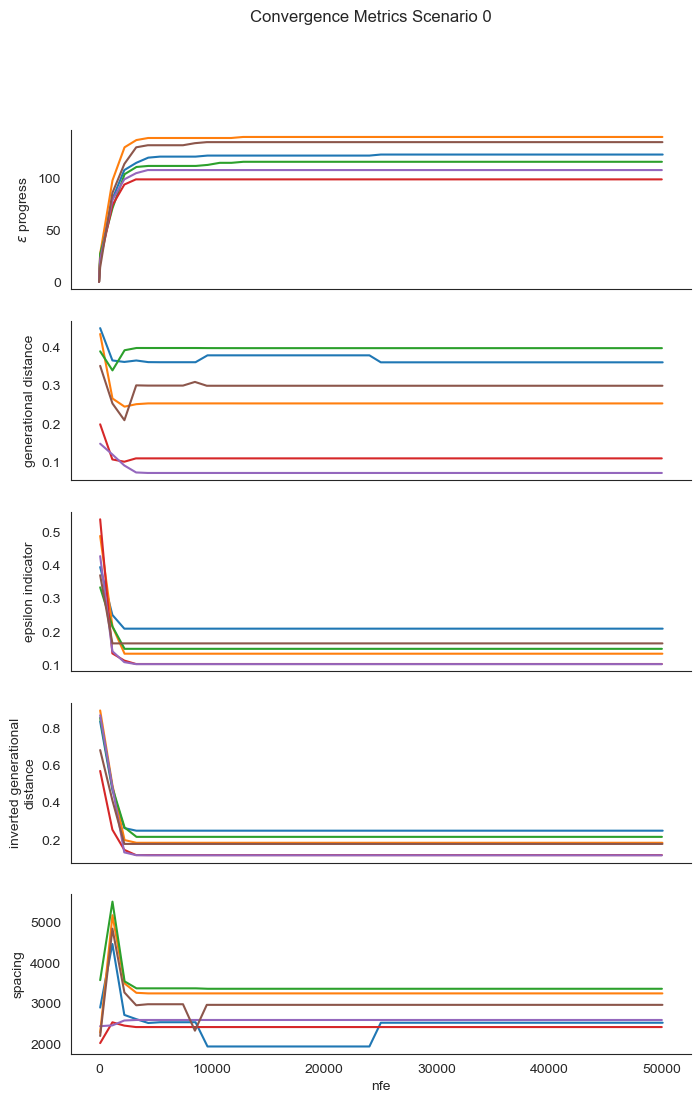

In [16]:
sns.set_style("white")

fig, axes = plt.subplots(nrows=5, figsize=(8, 12), sharex=True)

ax2, ax3, ax4, ax5, ax6 = axes

for metrics, convergence in zip(metrics_by_seed_scen0, scenario_0_convergences):

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

ax6.set_xlabel("nfe")


sns.despine(fig)

fig.suptitle('Convergence Metrics Scenario 0')



plt.show()

### Scenario 1

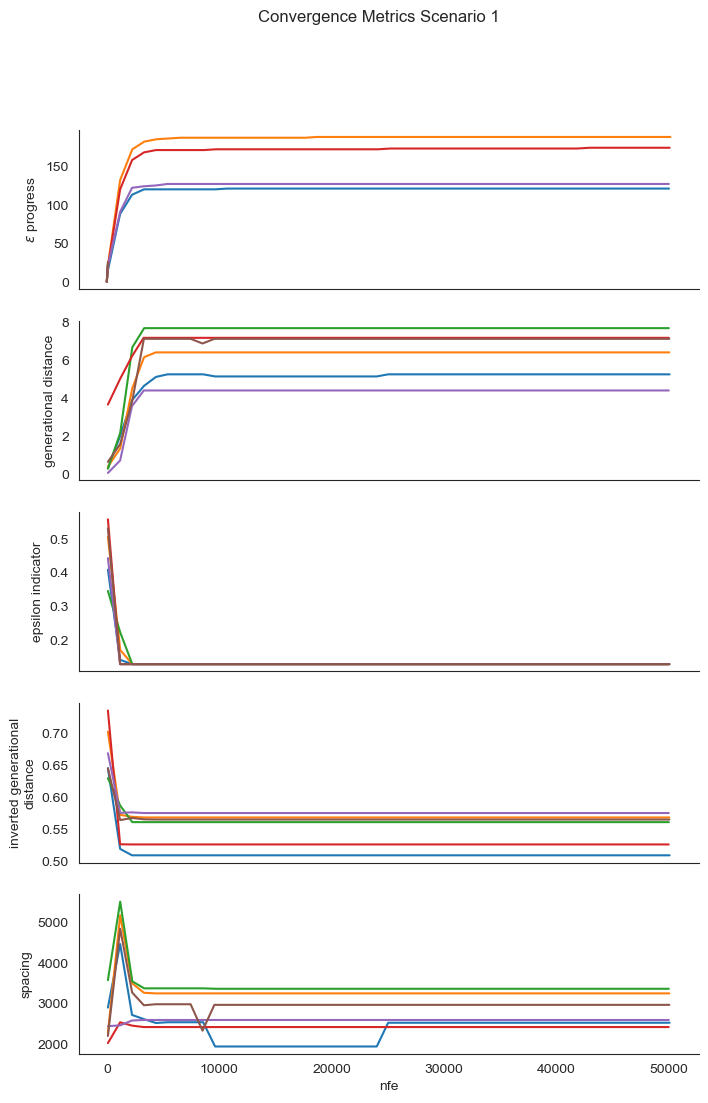

In [21]:
sns.set_style("white")
fig, axes = plt.subplots(nrows=5, figsize=(8, 12), sharex=True)

ax2, ax3, ax4, ax5, ax6 = axes

for metrics, convergence in zip(metrics_by_seed_scen1, scenario_1_convergences):
    # ax1.plot(metrics.nfe, metrics.hypervolume)
    # ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

ax6.set_xlabel("nfe")

fig.suptitle('Convergence Metrics Scenario 1')
sns.despine(fig)

plt.show()